In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
plt.rc('axes', titlesize=20)  # fontsize of the figure title

# Surrogate Design Results

## Pricetaker Results

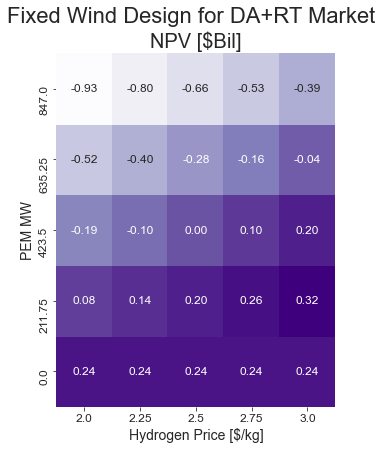

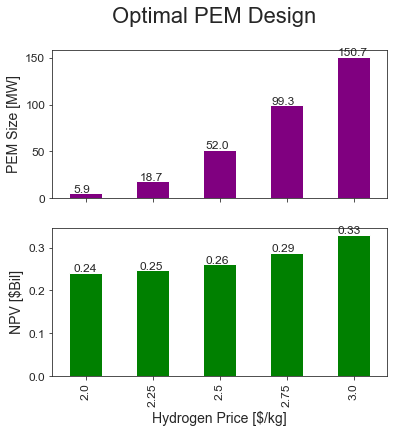

In [2]:
res_df = pd.read_csv("wind_PEM/design_wind_PEM_results.csv").drop('Unnamed: 0', axis=1)
res_df['NPV [$Bil]'] = res_df['NPV'] * 1e-9
colormaps = [sns.color_palette("Purples", as_cmap=True), # NPV
             sns.color_palette("Greens", as_cmap=True), # PEM
             ]

def plot_results(results, title):
    fig, axs = plt.subplots(1, 1, figsize=(5, 6.5), sharex=True, sharey=True)
    sns.heatmap(results.pivot_table(index='pem_mw', 
                                    columns="h2_price_per_kg", 
                                    values='NPV [$Bil]',
                                    aggfunc='mean'), annot=True, fmt=".2f", ax=axs,
                                    cbar=False, cmap=colormaps[0]
                                    )
    axs.set_title("NPV [$Bil]")
    axs.set_xlabel("Hydrogen Price [$/kg]")
    axs.set_ylabel("PEM MW")
    axs.invert_yaxis()
    fig.suptitle(title)

pem_sizes = np.linspace(0, 1, 5) * 847
plot_results(res_df[res_df['pem_mw'].isin(pem_sizes)], "Fixed Wind Design for DA+RT Market")

opt_df = res_df[~res_df['pem_mw'].isin(pem_sizes)][['pem_mw', 'NPV [$Bil]', 'h2_price_per_kg']]
opt_df.set_index("h2_price_per_kg", inplace=True)
axes = opt_df.plot.bar(subplots=True, color={"pem_mw": "purple", "NPV [$Bil]": "green"}, figsize=(6, 6), legend=None
)
axes[0].set_xlabel("Hydrogen Price [$/kg]")
axes[1].set_xlabel("Hydrogen Price [$/kg]")
axes[0].set_ylabel("PEM Size [MW]")
axes[0].set_title("")
axes[1].set_title("")
axes[1].set_ylabel("NPV [$Bil]")
plt.suptitle("Optimal PEM Design")

for ax in axes:
    for n, p in enumerate(ax.patches):
        ax.annotate(str(round(p.get_height(), 2)), (n * p.get_width() * 1.97 + -.18, p.get_height() * 1.01))


## Surrogate Results

Text(0.5, 1.0, 'Wind-PEM Marginal Cost Curve at T=t')

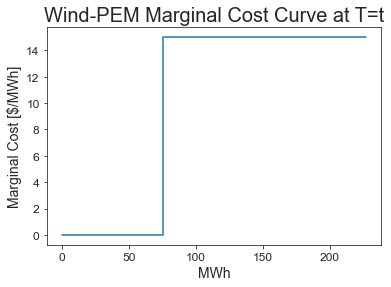

In [3]:
mws = np.linspace(0, 227.05, 10)
m_cost = [0 if mw < (227.05 - 127.05) else 15 for mw in mws]
plt.step(mws, m_cost)
plt.xlabel("MWh")
plt.ylabel("Marginal Cost [$/MWh]")
plt.title("Wind-PEM Marginal Cost Curve at T=t")

In [4]:
import glob
import numpy as np
from dispatches.case_studies.renewables_case.double_loop_utils import read_rts_gmlc_wind_inputs
from dispatches_sample_data import rts_gmlc
from dispatches.case_studies.renewables_case.load_parameters import wind_cap_cost, wind_op_cost, pem_cap_cost, pem_op_cost, pem_var_cost, PA
from dispatches_data.api import files

rt_revenue_only = True
include_wind_capital_cost = False

wind_cf = read_rts_gmlc_wind_inputs(rts_gmlc.source_data_path, gen_name="303_WIND_1", agg_func="first")['303_WIND_1-RTCF']
results_file_pattern = f"RE/input_data/sweep_parameters_15_1000.csv"
params_file = files("dynamic_sweep", pattern=results_file_pattern)
if not params_file:
    raise LookupError(f"No files found with pattern {results_file_pattern}")
params = pd.read_csv(params_file[0])

records = []
csv_files_to_load = files("dynamic_sweep", pattern=f"RE/results_parameter_sweep_15_1000/*.csv")
for filename in csv_files_to_load:
    res = pd.read_csv(filename)
    ind = int(Path(filename).stem.split('_')[-1])
    pem_bid = params['PEM_bid'][ind]
    pem_size = params['PEM_power_capacity'][ind]
    if rt_revenue_only:
        e_revenue =(res["Dispatch"] * res["LMP"]).sum()
    else:
        e_revenue = (res["Dispatch DA"] * res["LMP DA"] + (res["Dispatch"] - res["Dispatch DA"]) * res["LMP"]).sum()
    pem_elec = np.clip(wind_cf.values * 847 - res['Dispatch'], 0, pem_size)
    h2_price = 3
    h_revenue = pem_elec.sum() / 54.953 * h2_price * 1e3
    cap_cost = (847 * wind_cap_cost * int(include_wind_capital_cost) + pem_size * pem_cap_cost) * 1e3 
    fixed_op_cost = (847 * wind_op_cost + pem_size * pem_op_cost) * 1e3
    var_op_cost = pem_var_cost * pem_elec.sum()
    npv = -cap_cost + PA * (e_revenue + h_revenue - fixed_op_cost - var_op_cost)
    records.append({
        "e_revenue": e_revenue,
        "h_revenue": h_revenue,
        "pem_bid": pem_bid,
        "pem_mw": pem_size,
        'NPV': npv})
sweep_results = pd.DataFrame(records)
sweep_results['pem_bid_round'] = sweep_results['pem_bid'].astype('int')
sweep_results['pem_mw_round'] = sweep_results['pem_mw'].astype('int')
sweep_results['e_revenue_mil'] = (sweep_results['e_revenue'] * 1e-6)
sweep_results['h_revenue_mil'] = (sweep_results['h_revenue'] * 1e-6)
sweep_results['NPV_bil'] = (sweep_results['NPV'] * 1e-9)
sweep_results['NPV_mil'] = (sweep_results['NPV'] * 1e-6)


In [5]:
# get results file from RE_surrogate_optimization_steadystate.py
re_case_dir = Path.cwd()
results = pd.read_csv(re_case_dir / "surrogate_results_ss_rt_freewind.csv")
results = results.drop(columns=["Unnamed: 0", 'wind_mw'])
results['pem_bid_round'] = results['pem_bid'].astype('int')
results['pem_mw_round'] = results['pem_mw'].astype('int')
results['e_revenue_mil'] = (results['e_revenue'] * 1e-6)
results['h_revenue_mil'] = (results['h_revenue'] * 1e-6)
results['NPV_bil'] = (results['NPV'] * 1e-9)
results['NPV_mil'] = (results['NPV'] * 1e-6)
results

,pem_mw,pem_bid,e_revenue,h_revenue,NPV,freq_day_0,freq_day_1,freq_day_2,freq_day_3,freq_day_4,...,freq_day_16,freq_day_17,freq_day_18,freq_day_19,pem_bid_round,pem_mw_round,e_revenue_mil,h_revenue_mil,NPV_bil,NPV_mil
0,127.050,15.0,2.589545e+07,2.325268e+07,-4.903845e+07,0.028895,0.063540,0.427766,0.003281,0.000458,...,0.023888,0.005713,0.034070,0.073425,15,127,25.895454,23.252677,-0.049038,-49.038453
1,148.225,15.0,2.610811e+07,2.558055e+07,-5.442964e+07,0.025751,0.056873,0.427467,0.004410,0.000105,...,0.024191,0.012067,0.034141,0.073441,15,148,26.108106,25.580545,-0.054430,-54.429636
2,169.400,15.0,2.636102e+07,2.821743e+07,-5.588867e+07,0.022988,0.049106,0.426976,0.005417,0.000059,...,0.024992,0.018411,0.034165,0.073034,15,169,26.361021,28.217433,-0.055889,-55.888672
3,190.575,15.0,2.664577e+07,2.971821e+07,-6.977941e+07,0.021001,0.041341,0.426691,0.005945,0.000062,...,0.025733,0.023153,0.033734,0.071100,15,190,26.645769,29.718211,-0.069779,-69.779412
4,211.750,15.0,2.695285e+07,3.028625e+07,-9.391935e+07,0.019871,0.033633,0.426775,0.005686,0.001641,...,0.026239,0.025169,0.032097,0.065010,15,211,26.952846,30.286250,-0.093919,-93.919354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,338.800,45.0,1.700278e+07,7.087716e+07,4.707778e+07,0.079991,0.004136,0.389319,0.049944,0.047801,...,0.120509,0.066808,0.000282,0.002565,45,338,17.002781,70.877158,0.047078,47.077778
191,359.975,45.0,1.693799e+07,7.369737e+07,4.410589e+07,0.079942,0.004292,0.389276,0.055595,0.026800,...,0.120158,0.067412,0.000584,0.002580,45,359,16.937986,73.697374,0.044106,44.105892
192,381.150,45.0,1.689122e+07,7.542054e+07,2.898666e+07,0.080035,0.004216,0.389166,0.059080,0.013766,...,0.119731,0.067629,0.000838,0.002450,45,381,16.891219,75.420543,0.028987,28.986663
193,402.325,45.0,1.685784e+07,7.611988e+07,2.492097e+06,0.080240,0.004013,0.389038,0.061097,0.006632,...,0.119420,0.067614,0.000902,0.002229,45,402,16.857842,76.119881,0.002492,2.492097


In [6]:
elec_rev_min = min(results['e_revenue_mil'].min(), sweep_results['e_revenue_mil'].min())
elec_rev_max = max(results['e_revenue_mil'].max(), sweep_results['e_revenue_mil'].max())
h2_rev_min = min(results['h_revenue_mil'].min(), sweep_results['h_revenue_mil'].min())
h2_rev_max = max(results['h_revenue_mil'].max(), sweep_results['h_revenue_mil'].max())
npv_min = min(results['NPV_bil'].min(), sweep_results['NPV_bil'].min())
npv_max = max(results['NPV_bil'].max(), sweep_results['NPV_bil'].max())

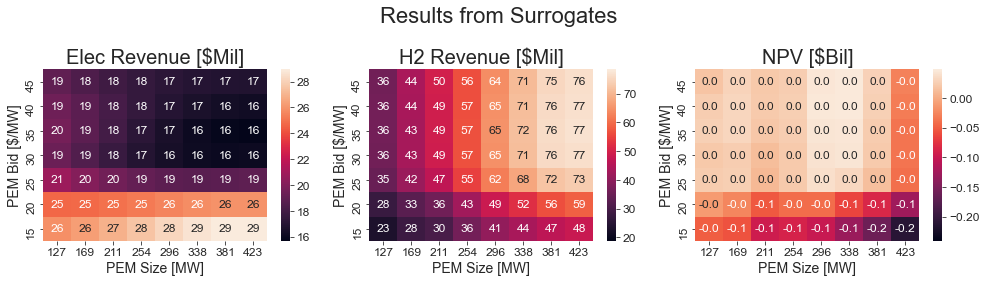

In [7]:
common_bids = set(results['pem_bid'].unique()).intersection(set(sweep_results['pem_bid'].unique()))
common_sizes = set(results['pem_mw'].round(2).unique()).intersection(set(sweep_results['pem_mw'].round(2).unique()))
results = results[(results['pem_bid'].isin(common_bids)) & (results['pem_mw'].round(2).isin(common_sizes))]

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='e_revenue_mil',
                                aggfunc='mean'), annot=True, fmt=".0f", ax=axs[0],
                                vmin=elec_rev_min, vmax=elec_rev_max)
axs[0].set_title("Elec Revenue [$Mil]")
axs[0].set_xlabel("PEM Size [MW]")
axs[0].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='h_revenue_mil',
                                aggfunc='mean'), annot=True, fmt=".0f", ax=axs[1],
                                vmin=h2_rev_min, vmax=h2_rev_max)
axs[1].set_title("H2 Revenue [$Mil]")
axs[1].set_xlabel("PEM Size [MW]")
axs[1].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='NPV_bil',
                                aggfunc='mean'), annot=True, fmt=".1f", ax=axs[2],
                                vmin=npv_min, vmax=npv_max)
axs[2].set_title("NPV [$Bil]")
axs[2].set_xlabel("PEM Size [MW]")
axs[2].set_ylabel("PEM Bid [$/MW]")

for ax in axs:
    ax.invert_yaxis()

plt.suptitle("Results from Surrogates")
plt.tight_layout()

## Compare with Input Dataset from Prescient Sweep

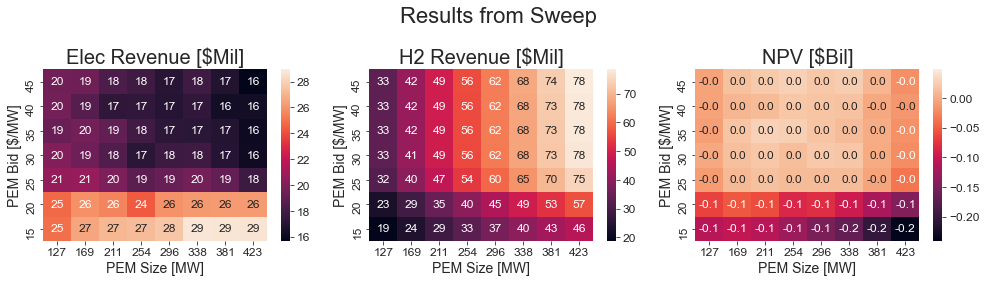

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(sweep_results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='e_revenue_mil',
                                aggfunc='mean'), annot=True, fmt=".0f", ax=axs[0],
                                vmin=elec_rev_min, vmax=elec_rev_max)
axs[0].set_title("Elec Revenue [$Mil]")
axs[0].set_xlabel("PEM Size [MW]")
axs[0].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(sweep_results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='h_revenue_mil',
                                aggfunc='mean'), annot=True, fmt=".0f", ax=axs[1],
                                vmin=h2_rev_min, vmax=h2_rev_max)
axs[1].set_title("H2 Revenue [$Mil]")
axs[1].set_xlabel("PEM Size [MW]")
axs[1].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(sweep_results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='NPV_bil',
                                aggfunc='mean'), annot=True, fmt=".1f", ax=axs[2],
                                vmin=npv_min, vmax=npv_max)
axs[2].set_title("NPV [$Bil]")
axs[2].set_xlabel("PEM Size [MW]")
axs[2].set_ylabel("PEM Bid [$/MW]")

for ax in axs:
    ax.invert_yaxis()

plt.suptitle("Results from Sweep")
plt.tight_layout()

In [9]:
sweep_results.sort_values("NPV")

,e_revenue,h_revenue,pem_bid,pem_mw,NPV,pem_bid_round,pem_mw_round,e_revenue_mil,h_revenue_mil,NPV_bil,NPV_mil
44,2.866167e+07,4.574726e+07,15.0,423.50,-2.405432e+08,15,423,28.661667,45.747255,-0.240543,-240.543244
37,2.871463e+07,4.313607e+07,15.0,381.15,-2.013595e+08,15,381,28.714629,43.136075,-0.201359,-201.359498
29,2.877705e+07,4.009267e+07,15.0,338.80,-1.669351e+08,15,338,28.777054,40.092667,-0.166935,-166.935140
21,2.762321e+07,3.676410e+07,15.0,296.45,-1.494136e+08,15,296,27.623206,36.764103,-0.149414,-149.413553
46,2.625689e+07,5.667063e+07,20.0,423.50,-1.446427e+08,20,423,26.256890,56.670634,-0.144643,-144.642676
14,2.732840e+07,3.287197e+07,15.0,254.10,-1.285656e+08,15,254,27.328403,32.871966,-0.128566,-128.565587
38,2.625400e+07,5.280056e+07,20.0,381.15,-1.202600e+08,20,381,26.254001,52.800561,-0.120260,-120.260024
0,2.491640e+07,1.880288e+07,15.0,127.05,-1.101554e+08,15,127,24.916395,18.802876,-0.110155,-110.155380
6,2.718628e+07,2.862496e+07,15.0,211.75,-1.099938e+08,15,211,27.186285,28.624960,-0.109994,-109.993787
53,2.659871e+07,2.383570e+07,15.0,169.40,-1.025414e+08,15,169,26.598713,23.835702,-0.102541,-102.541364


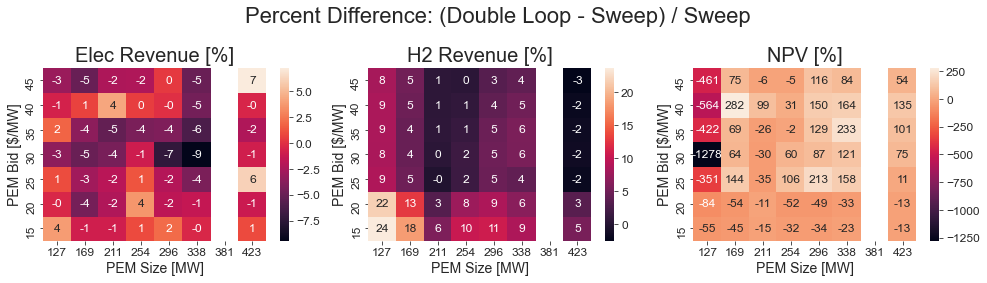

In [10]:
def calc_diff_df(value):
    sweep_diff = sweep_results[(sweep_results['pem_bid'].isin(common_bids)) & (sweep_results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean')
    diff_df = (results[(results['pem_bid'].isin(common_bids)) & (results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean') - sweep_diff) / sweep_diff
    return diff_df * 1e2

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(calc_diff_df('e_revenue_mil'), annot=True, fmt=".0f", ax=axs[0])
axs[0].set_title("Elec Revenue [%]")
axs[0].set_xlabel("PEM Size [MW]")
axs[0].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('h_revenue_mil'), annot=True, fmt=".0f", ax=axs[1])
axs[1].set_title("H2 Revenue [%]")
axs[1].set_xlabel("PEM Size [MW]")
axs[1].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('NPV_bil'), annot=True, fmt=".0f", ax=axs[2])
axs[2].set_title("NPV [%]")
axs[2].set_xlabel("PEM Size [MW]")
axs[2].set_ylabel("PEM Bid [$/MW]")

for ax in axs:
    ax.invert_yaxis()

plt.suptitle("Percent Difference: (Double Loop - Sweep) / Sweep")
plt.tight_layout()

-1.690874519190146 -0.1253745542353819
-2.011101931908186 1.6612898632023523
-0.018033667341989697 0.01607443260913001


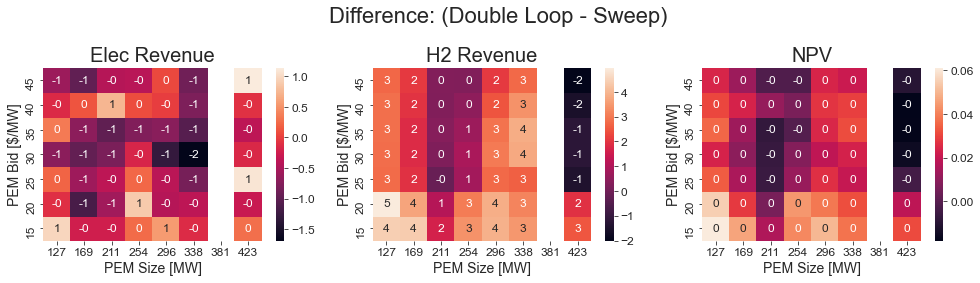

In [11]:
def calc_diff_df(value):
    sweep_diff = sweep_results[(sweep_results['pem_bid'].isin(common_bids)) & (sweep_results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean')
    diff_df = (results[(results['pem_bid'].isin(common_bids)) & (results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean') - sweep_diff)
    print(min(diff_df.min()), min(diff_df.max()))
    return diff_df

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(calc_diff_df('e_revenue_mil'), annot=True, fmt=".0f", ax=axs[0])
axs[0].set_title("Elec Revenue")
axs[0].set_xlabel("PEM Size [MW]")
axs[0].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('h_revenue_mil'), annot=True, fmt=".0f", ax=axs[1])
axs[1].set_title("H2 Revenue")
axs[1].set_xlabel("PEM Size [MW]")
axs[1].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('NPV_bil'), annot=True, fmt=".0f", ax=axs[2])
axs[2].set_title("NPV")
axs[2].set_xlabel("PEM Size [MW]")
axs[2].set_ylabel("PEM Bid [$/MW]")

for ax in axs:
    ax.invert_yaxis()

plt.suptitle("Difference: (Double Loop - Sweep)")
plt.tight_layout()

## Compare day frequencies

/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_6696/1946447195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results[f'percent_day_{day}'] = results[f'freq_day_{day}'] * 1e2


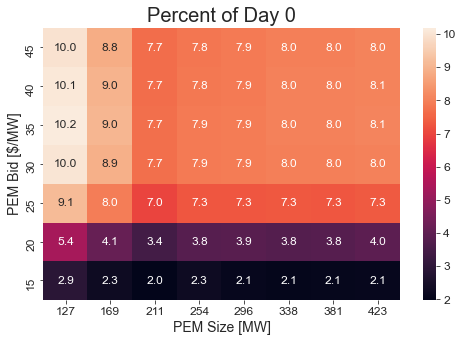

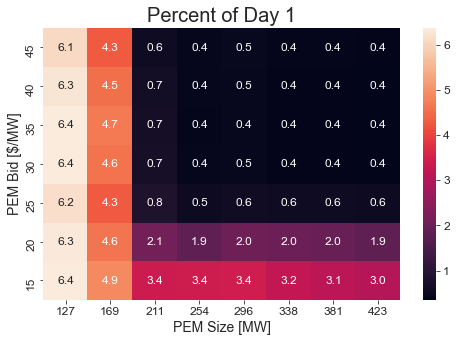

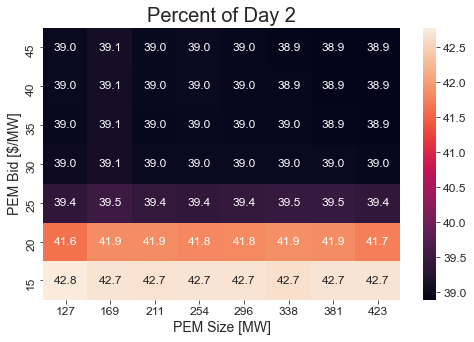

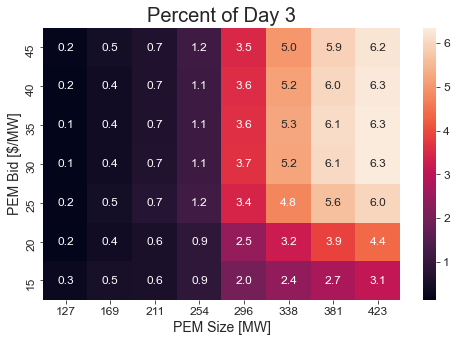

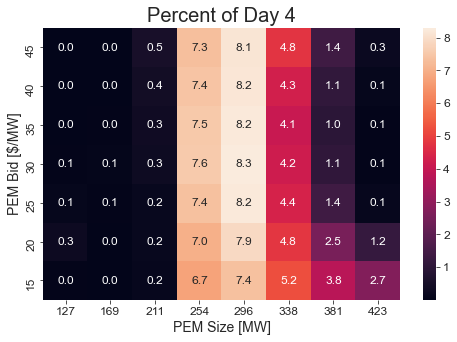

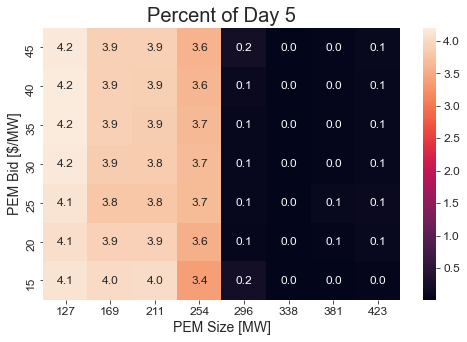

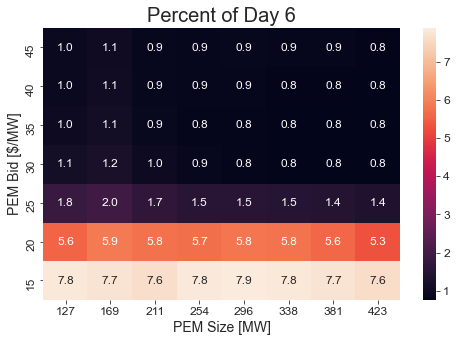

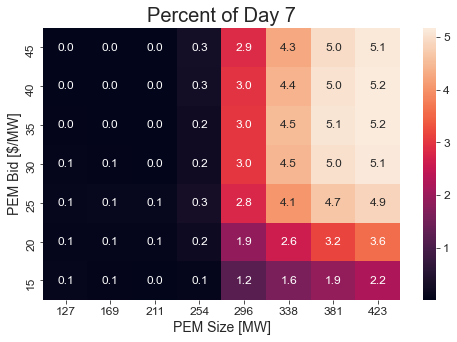

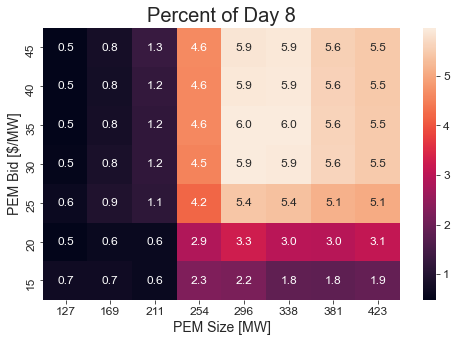

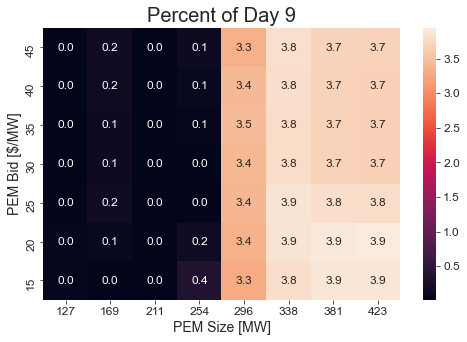

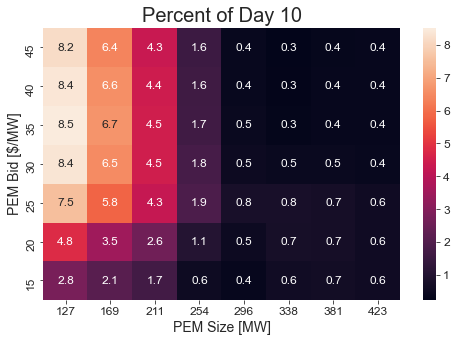

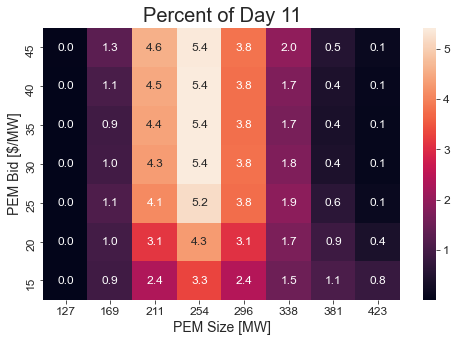

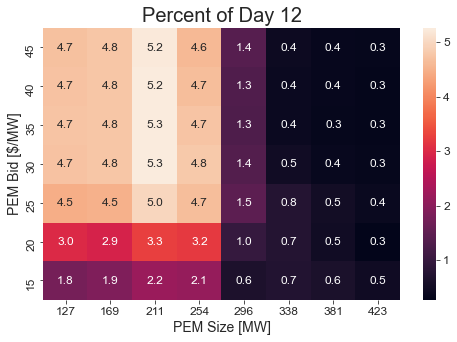

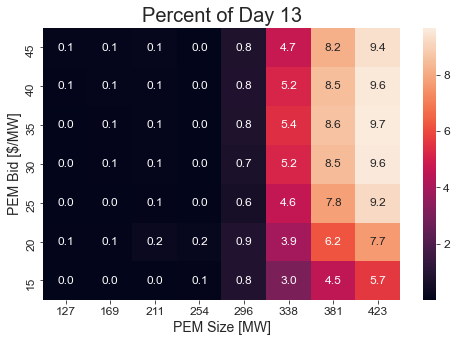

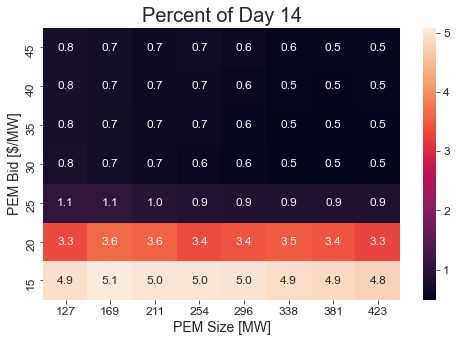

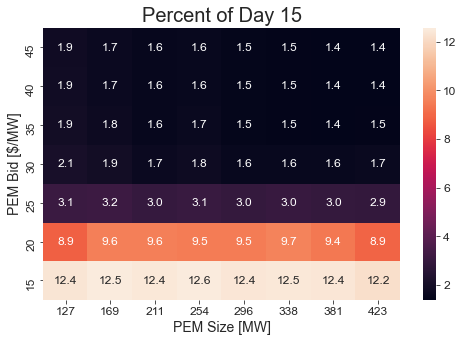

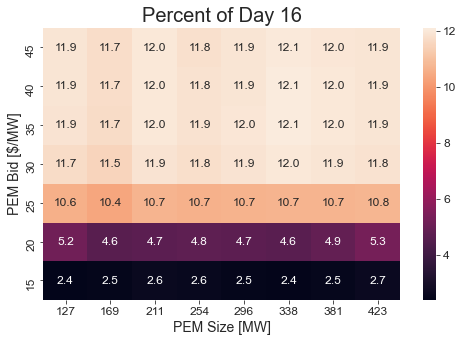

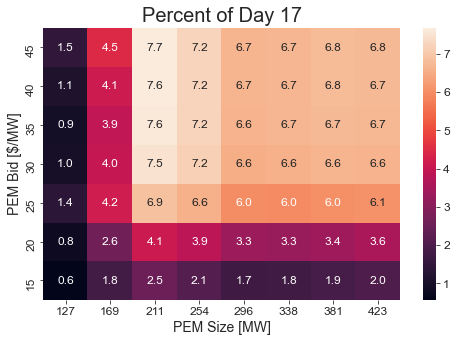

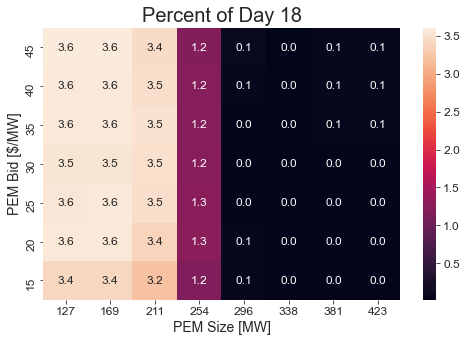

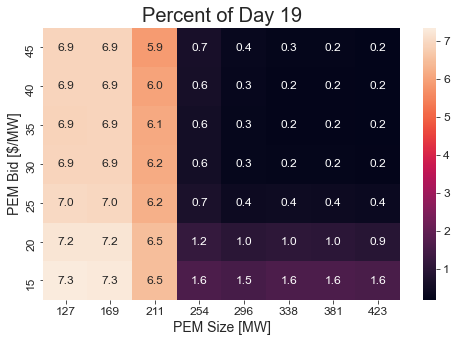

In [12]:
for day in range(20):
    results[f'percent_day_{day}'] = results[f'freq_day_{day}'] * 1e2
    fig, axs = plt.subplots(1, 1, figsize=(8, 5))
    sns.heatmap(results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=f'percent_day_{day}',
                                aggfunc='mean'), annot=True, fmt=".1f", ax=axs)
    axs.set_title(f"Percent of Day {day}")
    axs.set_xlabel("PEM Size [MW]")
    axs.set_ylabel("PEM Bid [$/MW]")
    axs.invert_yaxis()